# Titanic Top 4% with ensemble modeling

## 1. Introduction
* **Feature analysis**
* **Featuer engineering**
* **Modeling**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')


from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep', font_scale = 1.5)

import warnings
warnings.filterwarnings('ignore')

## 2. Load and Check data
### 2.1 Load data

In [2]:
# load train & test data
train = pd.read_csv("/Users/kimjw/Desktop/Kaggle/week1/train.csv")
test = pd.read_csv("/Users/kimjw/Desktop/Kaggle/week1/test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [3]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
#         print(col, Q1, Q3, outlier_step)
        
        outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col] > Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    # Counter() : 컨테이너에 동일한 값의 자료가 몇개인지를 파악하는데 사용 -> '키-값' 형태로 출력
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outliers_to_Drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
print(Outliers_to_Drop)

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [4]:
train.loc[Outliers_to_Drop] # 이상값으로 결정된 행을 출력(10개)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상값이 탐지되었다. 

In [5]:
# 이상값 제거
train = train.drop(Outliers_to_Drop, axis=0).reset_index(drop=True) # axis가 0이면 행 방향으로, 1이면 열 방향으로 작동

### 2.3 Joining train and test set

In [6]:
# categorical conversion할 동안 트레인, 테스트 데이터 병합한 데이터셋 사용
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 2.4 check for null and missing values

In [7]:
# 결측값 채우기
datase = dataset.fillna(np.nan)

# NULL value 확인
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age, Cabin에서 결측값이 많다. Survived에서 생긴 결측값은 테스트 데이터를 병합함으로써 생긴 결측값이다(테스트 데이터 자체에 Survivied 변수가 없었기 때문에 병합하면서 NaN값이 할당된 것)

In [8]:
# Info
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes # 각 변수별로 데이터타입 확인

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train.describe() # 트레인데이터 요약통계량

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis
### 3.1 Numerical values

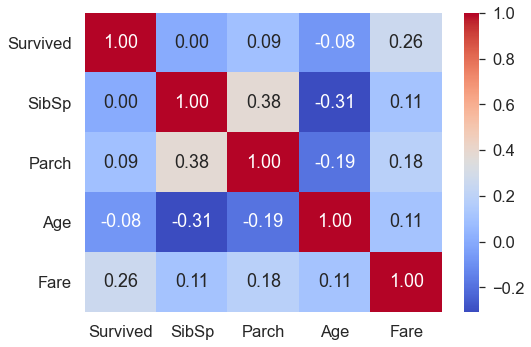

In [12]:
# numerical value : SibSp, Parch, Age, Fare & Survived 간의 상관관계
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

Survived와 Fare만 유의미한 상관관계가 있다고 판단된다. <br>
하지만 다른 변수들이 유용하지 않다는 것은 아니다. 이들 변수의 소집단이 Survival과 상관관계가 있을 수도 있기 때문이다. 변수별로 자세히 관계를 알아보기로 하자.

#### SibSp

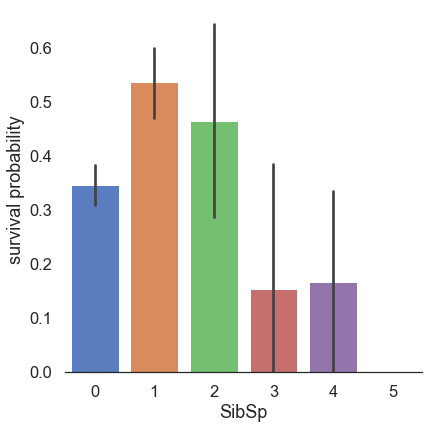

In [13]:
g = sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True) # 왼쪽 축이 사라지도록
g = g.set_ylabels("survival probability")

형제자매가 많은 탑승객들이 살아남을 확률이 적다. 때문에 새로운 변수로 범주화하려 한다.(3, 4, 5)

#### Parch

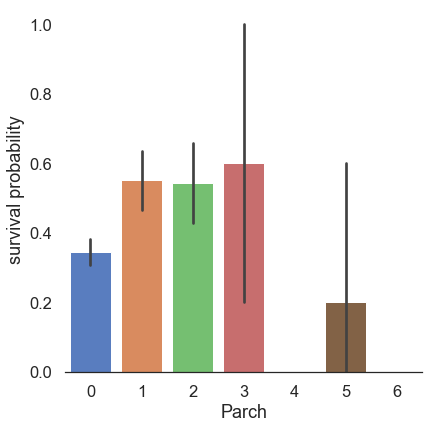

In [14]:
g = sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

부모자녀 수가 적을수록(소규모 가족) 살아남을 확률이 높다.
<br>
부모자녀 수가 3인 경우에는 표준편차가 심하다는 것을 기억해두어야 한다.

#### Age

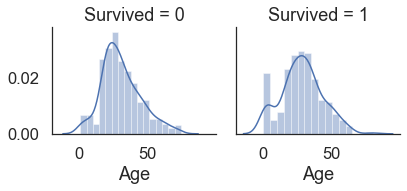

In [15]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

Age 분포는 가우시안 분포와 비슷하다.
<br>
Survived 여부에 따른 두 집단의 분포가 비슷하지 않다. 젋은 승객들에서 피크가 관찰된다. 60-80대 연령의 승객들은 상대적으로 살아남지 못했다.
<br>
Age와 Survived 간 상관관계가 유의하지 않더라도, 살아남을 확률에 대해 특정 연령 범주가 있다는 것을 알 수 있다.
<br>
매우 어린 승객들이 살아남을 확률이 높다.

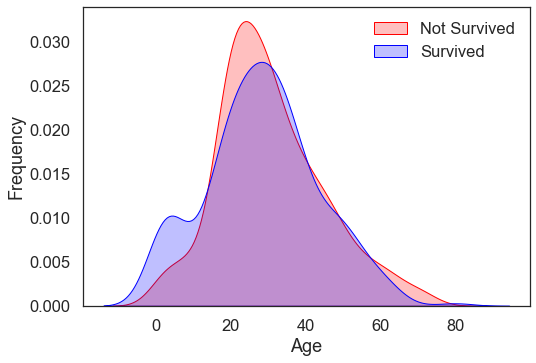

In [16]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1 & (train["Age"].notnull()))], ax=g, color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

두 밀도함수를 비교했을 때, 0-5사이 연령대의 어린 승객들에게서 피크가 있음을 볼 수 있다.

#### Fare

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
# 중위수로 결측값 채우기(중위수는 이상값들에 민감하게 반응하지 않으므로 훗날 예측에 많은 영향을 주지 않을 것이다)
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

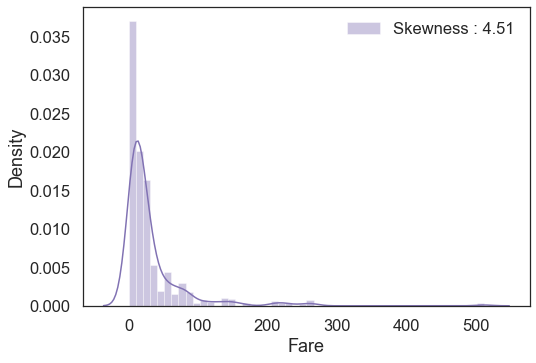

In [19]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset["Fare"].skew()))
g = g.legend(loc = 'best')

Fare 분포는 매우 치우쳐져 있다. 로그 변환을 취해 기울어짐을 완화시키자.

In [20]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i>0 else 0)

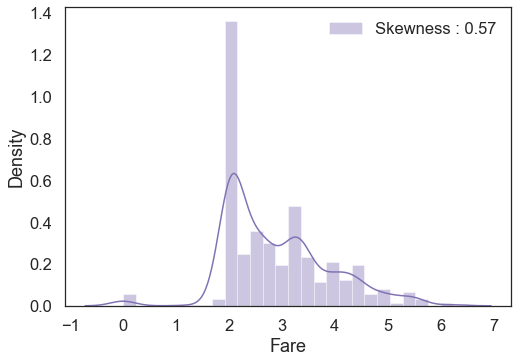

In [21]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset["Fare"].skew()))
g = g.legend(loc = 'best')

기울어짐 정도가 이전보다는 완화되었다.

### 3.2 Categorical Values

####  Sex

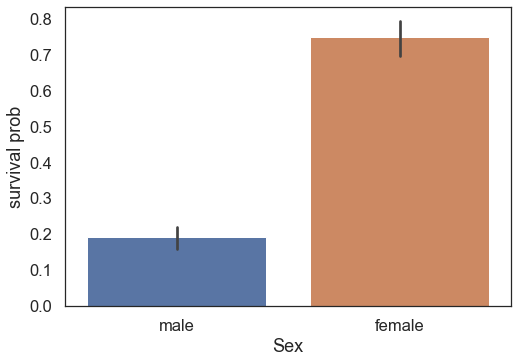

In [22]:
g = sns.barplot(x="Sex", y="Survived", data=train)
g = g.set_ylabel("survival prob")

In [23]:
train[["Sex", "Survived"]].groupby("Sex").mean(0)

,Survived
Sex,
female,0.747573
male,0.190559


여성 승객이 살아남을 확률이 훨씬 높다
<br>
성별은 survival을 예측하는데 매우 중요한 변수로 보인다.

####  Pclass

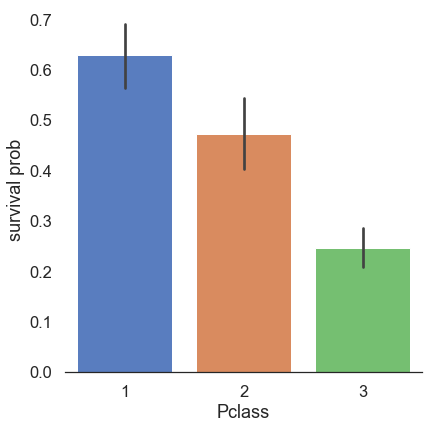

In [24]:
g = sns.factorplot(x="Pclass", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival prob")

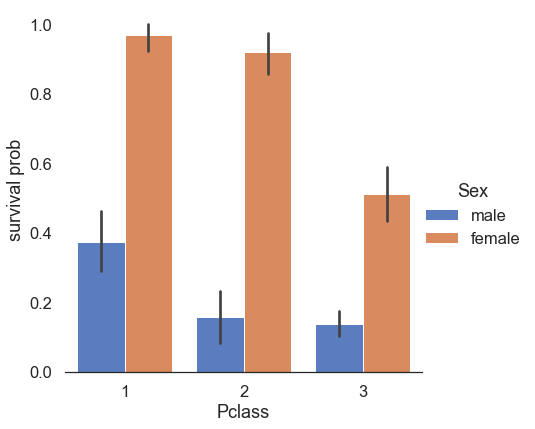

In [25]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival prob")

좌석 등급이 높을수록 살아남을 확률이 높다. 성별에 따른 분류를 해도 같은 결과를 관측할 수 있다

#### Embarked

In [26]:
# 결측값은 최빈값인 "S"로 대체
dataset["Embarked"] = dataset["Embarked"].fillna("S")

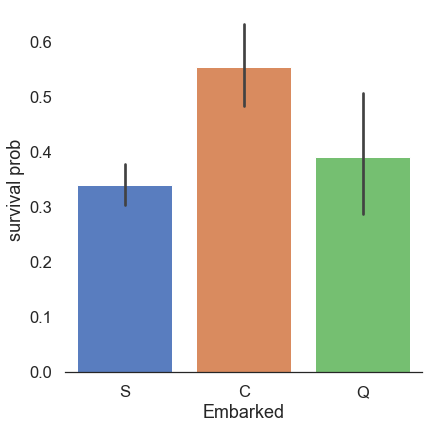

In [27]:
g = sns.factorplot(x="Embarked", y="Survived", data=train, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels('survival prob')

Cherbourg(C)에서 출발한 승객들의 생존률이 가장 높다.
<br>
가정을 해보자면, C에 일등석 승객들의 비율이 나머지 두 곳에 비해 높을 것 같다.

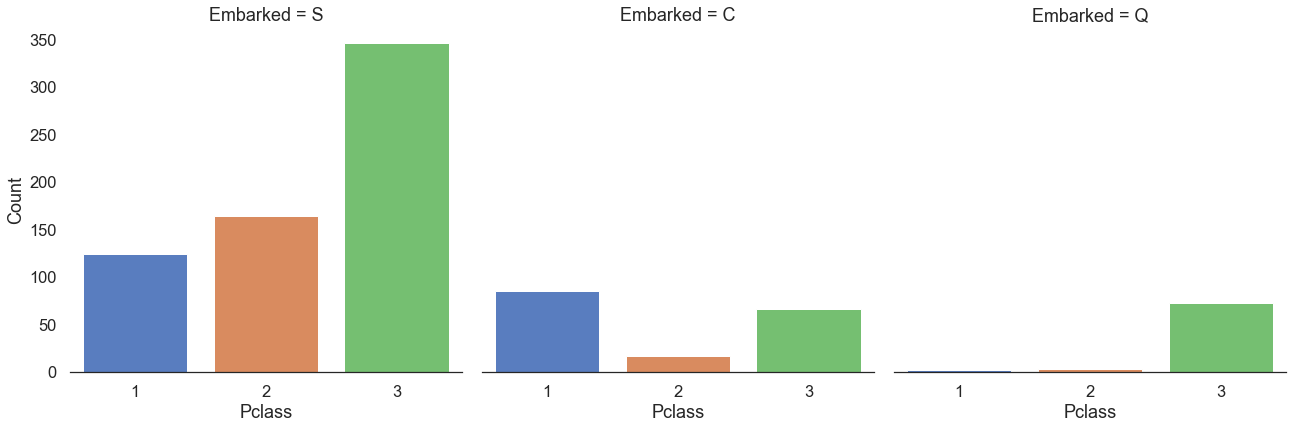

In [28]:
g = sns.factorplot("Pclass", col ="Embarked", data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

실제로 S와 Q엔 3등석 승객들이 많았다. 반면 C엔 1등석 승객이 가장 많았다.
<br>
왜 1등석에 탄 승객들의 생존률이 높은지 설명할 수는 없으나, 예측해보자면 1등석 승객들이 우선적으로 대피된 것 같다.

## Filling missing Values
### 4.1 Age

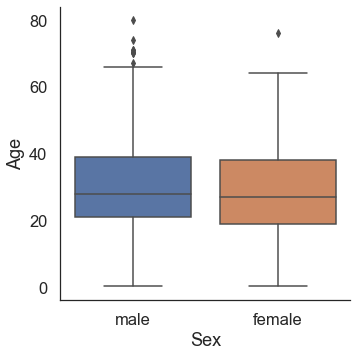

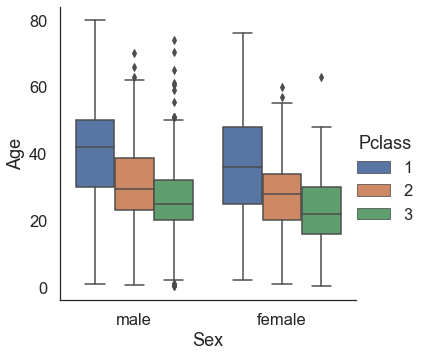

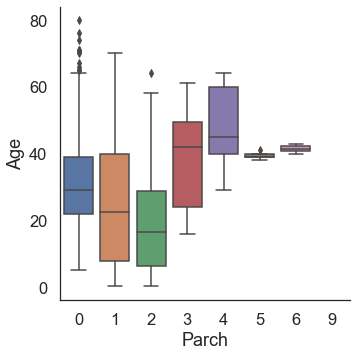

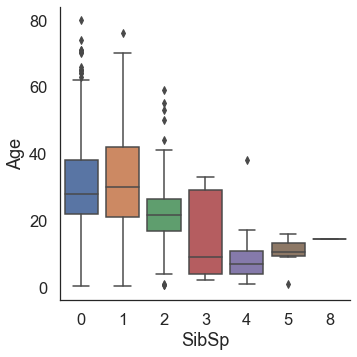

In [29]:
g = sns.factorplot(x="Sex", y="Age", data=dataset, kind="box")
g = sns.factorplot(x="Sex", y="Age", hue="Pclass", data=dataset, kind="box")
g = sns.factorplot(x="Parch", y="Age", data=dataset, kind="box")
g = sns.factorplot(x="SibSp", y="Age", data=dataset, kind="box")

연령 분포는 성별에 따른 차이가 없다. 그러므로 성별은 나이를 예측하는데 있어서 유의미한 변수가 아니다.
<br>
높은 등급(Pclass) 승객일수록 나이가 많다.
<br>
부모자녀수(Parch)가 많은 승객일수록 나이가 많다. 형제자매(SibSp)가 많은 승객일수록 나이가 어리다.

In [30]:
# 성별을 1, 0으로 변환
dataset["Sex"] = dataset["Sex"].map( { "male": 0, "female": 1} )

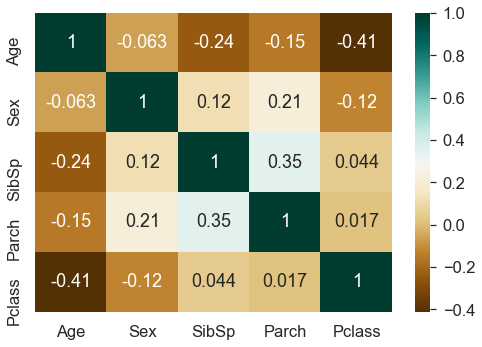

In [31]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(), cmap="BrBG", annot=True)

상관관계가 Parch를 제외하고는 factorplots에서의 결과와 일치한다.(Age는 Sex와 관련이 없지만, Pclass,Parch,SibSp와는 negative하게 연관이 있다)
<br>
Age & Parch plot에서는 연령이 높을수록 부모자녀수가 높았다. 하지만 상관관계는 negative하게 도출되었다.
<br>
SibSp, Parch, Pclass를 이용해 Age의 결측값을 채우려고 한다.

In [32]:
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset["SibSp"]==dataset.iloc[i]["SibSp"]) & (dataset["Parch"]==dataset.iloc[i]["Parch"]) &
                              (dataset["Pclass"]==dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else:
        dataset["Age"].iloc[i] = age_med

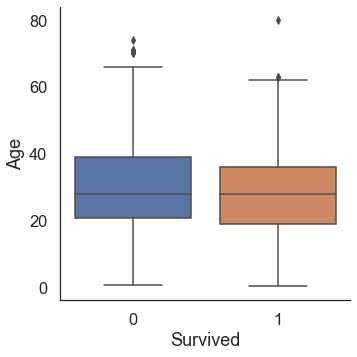

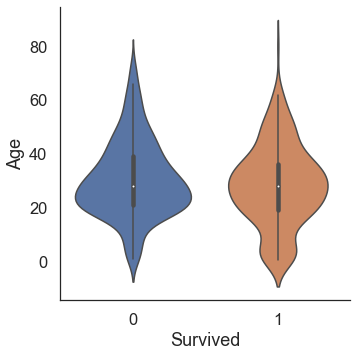

In [33]:
g = sns.factorplot(x="Survived", y="Age", data=train, kind="box")
g = sns.factorplot(x="Survived", y="Age", data=train, kind="violin")

violin plot에서 어린 연령대의 승객들이 더 높은 생존률을 가진다.

## Feature engineering
### 5.1 Name/Title

In [34]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [35]:
# Get title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


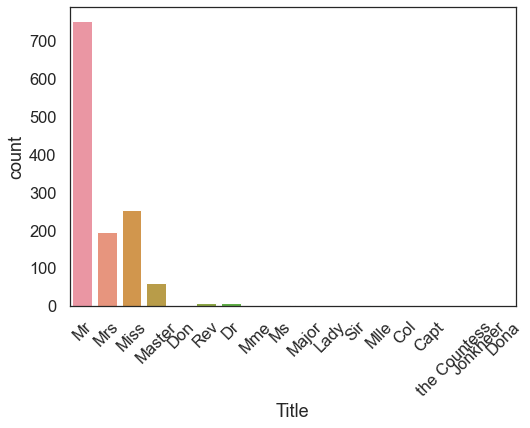

In [36]:
g = sns.countplot(x="Title", data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)
print(dataset["Title"].unique())

Mr, Mrs, Miss, Masster를 제외하고는 데이터가 희박하므로 4개 집단으로 범주화 예정

In [37]:
# Title 변수 범주화 작업
dataset["Title"] = dataset["Title"].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'], "Rare")
dataset["Title"] = dataset["Title"].map( { "Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3})
dataset["Title"] = dataset["Title"].astype(int)

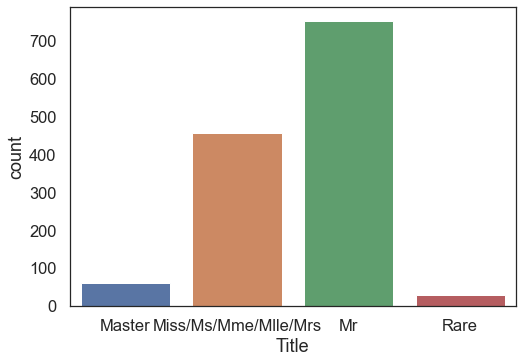

In [38]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

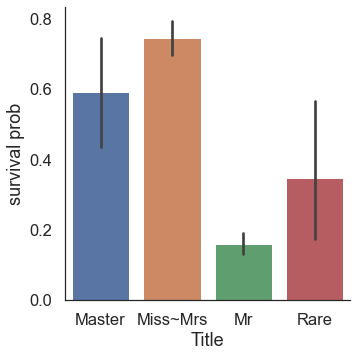

In [39]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss~Mrs", "Mr", "Rare"])
g = g.set_ylabels('survival prob')

여성과 아이들의 생존률이 높다.
<br>
흥미로운 점은 Rare한 성을 가진 승객들의 생존률이 꽤 높다는 것이다.

In [40]:
# Name에서 뽑아낸 유의미한 변수인 Title이 있으므로 Name은 drop
dataset.drop(labels=["Name"], axis=1, inplace=True)

### 5.2 Family Size
대규모 가족일수록 대피하기 어렵다고 추측할 수 있다. 
<br>
Fize라는 변수를 만들기로 결정 (= SibSp + Parch + 1)

In [41]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

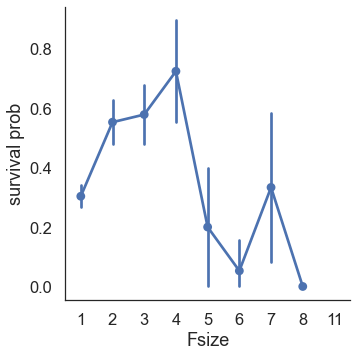

In [42]:
g = sns.factorplot(x="Fsize", y="Survived", data=dataset)
g = g.set_ylabels("survival prob")

가족 규모가 중요한 역할을 한다. 대규모 가족에서 생존률이 가장 낮다.
<br>
4개 집단으로 범주화 할 것(1 / 2 / 3~4 / 5~)

In [43]:
dataset["Single"] = dataset["Fsize"].map(lambda s: 1 if s == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s >= 5 else 0)

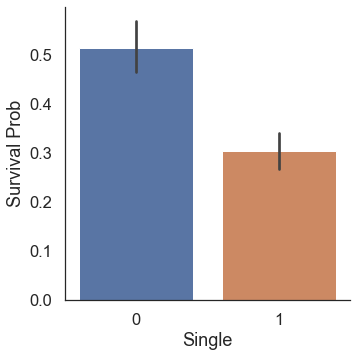

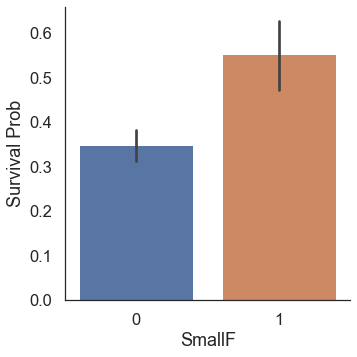

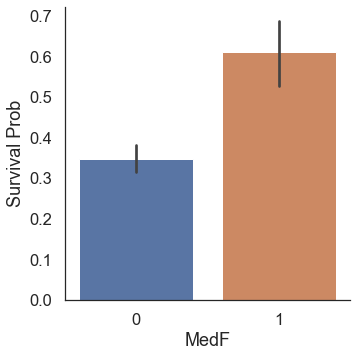

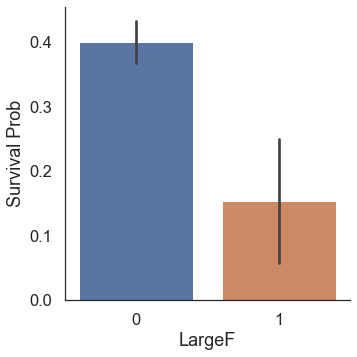

In [44]:
g = sns.factorplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Prob")
g = sns.factorplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Prob")
g = sns.factorplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Prob")
g = sns.factorplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Prob")

SmallF & MedF에서 생존률이 높다.

In [45]:
# Title과 Embarked 더미변수로 변환
dataset = pd.get_dummies(dataset, columns=["Title"])
dataset = pd.get_dummies(dataset, columns=["Embarked"], prefix="EM")

In [46]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,EM_C,EM_Q,EM_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


#### 5.3 Cabin

In [47]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [48]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [49]:
dataset["Cabin"].isnull().sum()

1007

In [50]:
# Cabin의 결측값은 'X'로 변환 & 맨 앞글자 알파벳만 추출(타이타닉호에서 승객들의 위치를 알려주는 요소)
dataset["Cabin"] = pd.Series(i[0] if not pd.isnull(i) else "X" for i in dataset["Cabin"])

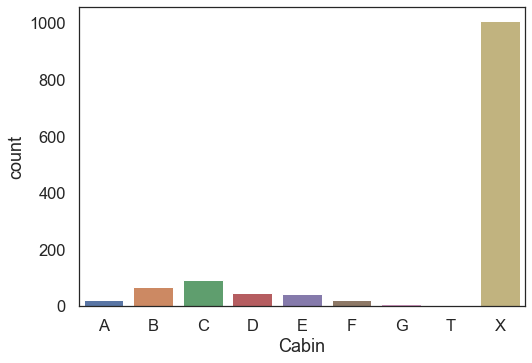

In [51]:
g = sns.countplot(dataset["Cabin"], order=["A","B","C","D","E","F","G","T","X"])

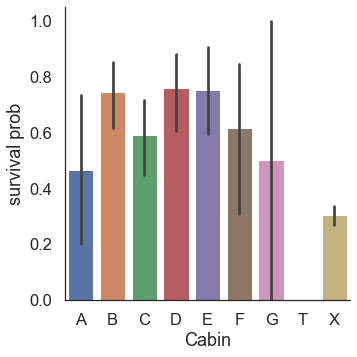

In [52]:
g = sns.factorplot(x="Cabin",y="Survived", data=dataset,kind="bar", order=["A","B","C","D","E","F","G","T","X"])
g = g.set_ylabels("survival prob")

객실을 가진 승객이 현저히 적기 때문에, 생존률은 큰 표준편차를 갖는다. 그래서 객실 간 생존률을 비교하기는 어려워 보인다
<br>
그렇지만 객실을 가진 승객이 객실이 없는 승객보다는 높은 생존률을 보이고 있는 것은 사실이다.
<br>
B,C,D,E,F에서 그러하다.

In [53]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin") # 여기서 왜 더미변수를 만드는 걸까?

In [54]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,EM_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,0,0,0,0,0,0,0,0,1


#### 5.3 Ticket

In [55]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [56]:
# 접두사만 가져오기, 없다면 X로 대체
Ticket = []
for i in dataset["Ticket"]:
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/","").strip().split(" ")[0])
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [57]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

In [58]:
dataset["Pclass"] = dataset["Pclass"].astype("category") # Pclass의 원래형은 int64, category형으로 바꿔줘야 하는 이유는?
dataset = pd.get_dummies(dataset, columns=["Pclass"], prefix="Pc") 

In [64]:
# 필요없는 변수 삭제
dataset.drop(labels=["PassengerId"], axis=1, inplace=True)

In [65]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## Modeling

In [66]:
# train / test 데이터 구분

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

In [67]:
# Survived 변수의 타입을 float64 -> int
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]
X_train = train.drop(labels=["Survived"], axis=1)

#### 6.1 Simple modeling
##### 6.1.1 Cross validate models
I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.
* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceptron(neural network)
* KNN
* Logistic Regression
* Liner Discriminat Analysis

In [68]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

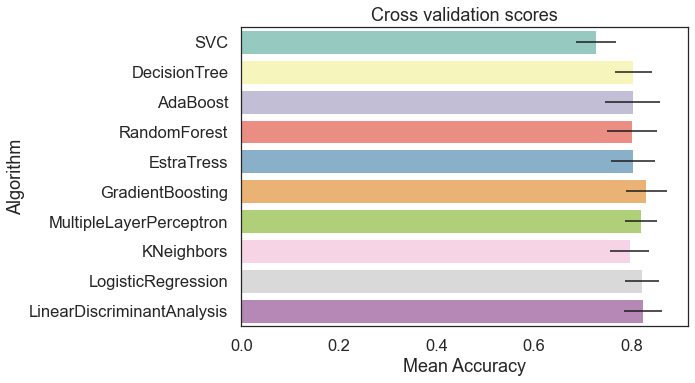

In [69]:
# Modeling step Test differents algorithms

random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv =kfold, n_jobs = 4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans': cv_means, "CrossValerrors": cv_std, "Algorithm":["SVC", 'DecisionTree', 'AdaBoost', 'RandomForest', 'EstraTress', "GradientBoosting", 'MultipleLayerPerceptron', 'KNeighbors', "LogisticRegression", 'LinearDiscriminantAnalysis']})

g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res, palette="Set3", orient = 'h', **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title('Cross validation scores')

SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 앙상블 모델링에 사용 예정

##### 6.1.2 Hyperparameter tunning for best models

In [70]:
# Meta Modeling 

# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = { "base_estimator__criterion": ["gini", "entropy"], "base_estimator__splitter": ["best", "random"],
                 "algorithm": ["SAMME", "SAMME.R"],
                 "n_estimators": [1,2],
                 "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 644 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   16.7s finished


In [71]:
gsadaDTC.best_score_

0.8241317671092953

In [72]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

ex_param_grid = { "max_depth": [None],
                "max_features": [1,3,10],
                "min_samples_split": [2,3,10],
                "min_samples_leaf": [1,3,10],
                "bootstrap": [False],
                "n_estimators": [100,300],
                "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   43.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.1min finished


0.8308605720122575

In [75]:
# Random Forest
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
                "max_features": [1,3,10],
                "min_samples_split": [2,3,10],
                "min_samples_leaf": [1,3,10],
                "bootstrap": [False],
                "n_estimators": [100,300],
                "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.3min finished


0.8342824310520941

In [76]:
# Gradient Boosting tunning
GBC = GradientBoostingClassifier()

gb_param_grid = {"loss": ["deviance"],
                "n_estimators": [100,200,300],
                "learning_rate": [0.1,0.05,0.01],
                "max_depth": [4,8],
                "min_samples_leaf":[100,150],
                "max_features":[0.3,0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.4min finished


0.8263534218590399

In [77]:
# SVC
SVMC = SVC(probability=True)

svc_parm_grid = {"kernel": ['rbf'],
                "gamma": [0.001,0.01,0.1,1],
                "C": [1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_parm_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.0min finished


0.8331332992849847

##### Plot Learning curves
Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

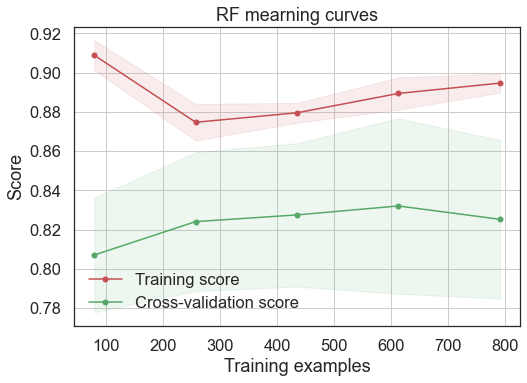

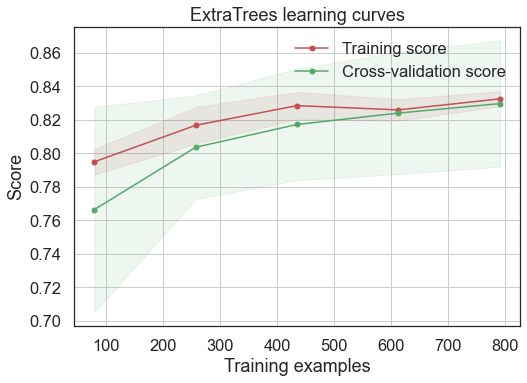

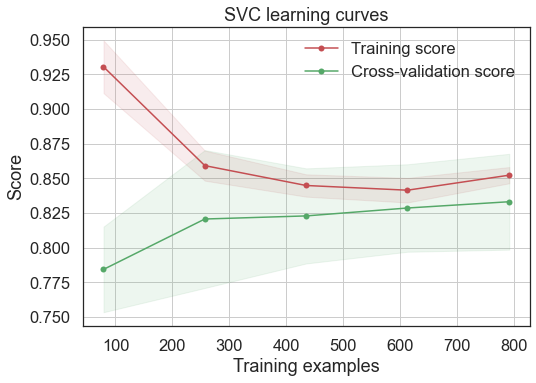

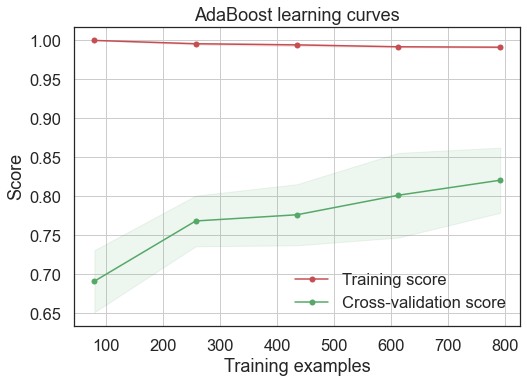

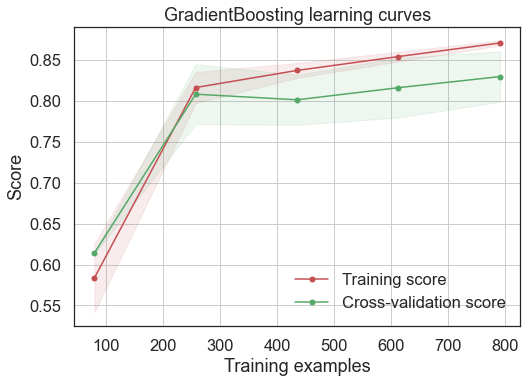

In [85]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim) #이게 무슨 뜻이지
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, "RF mearning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)

GradientBoosting and Adaboost classifier tend to overfit the training set. According to the growing cross-validation curves, GradientBoosting and Adaboost could perform better with more training examples.
<br>
SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

##### 6.1.4 Feature importance of tree based classifiers

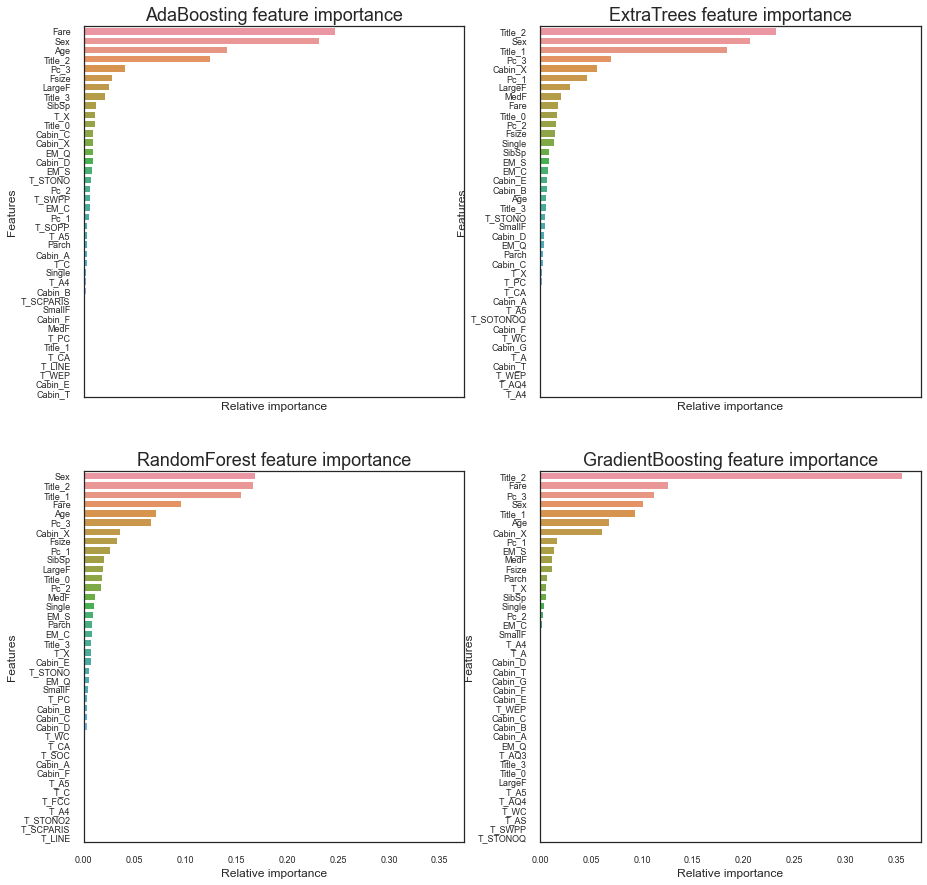

In [90]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex= "all", figsize = (15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

'Fare', 'Title_2', 'Age', 'Sex'변수가 공통적으로 importance feature이다.
<br>
'Title_2'는 'Sex'와 밀접하게 관련되어있다.
<br>
**According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the Family size and the social standing of the passengers more than the location in the boat.**

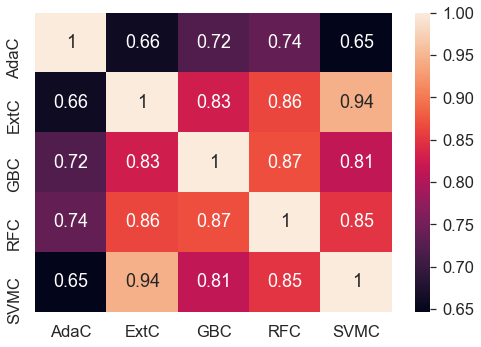

In [92]:
test_survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVMC")
test_survived_AdaC = pd.Series(ada_best.predict(test), name="AdaC")
test_survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# 모든 분류기 결과 합치기
ensemble_results = pd.concat([test_survived_AdaC, test_survived_ExtC, test_survived_GBC, test_survived_RFC, test_survived_SVMC], 
                             axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

Adaboost를 제외하고 5개 분류기의 예측 결과는 비슷하다.

### 6.2 Ensemble Modeling
#### 6.2.1 Combining models

In [93]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('ext', ExtC_best), ('svc', SVMC_best), ('adac', ada_best),
                                      ('gbc', GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction
#### 6.3.1 Predict and submit results

In [94]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")
results = pd.concat([IDtest, test_Survived], axis=1)

In [95]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
